# Example: Simulating a Network of Connected Agents
Fill me in.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-136/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Problem setup and constants
In this section, we set several constants that we'll use in the other tasks in this example. See the comment beside each value for a description of the constant and permissible values. Let's begin with constants associated with the rule and the world, and conclude by calculating the number of possible rules.

In [5]:
rule_index = 6735; # the Wolfram rule index, see below for the range of possible values
number_of_colors = 3; # each the number of colors, i.e., the number of possible states for each agent. 
radius = 4; # size of the neighborhood an agent looks at. DO NOT CHANGE
number_of_rows = 2^9; # number of rows in the 2D agent grid. Default: 512. Larger values will **slow down** the computation below
number_of_columns = 2^9; # number of cols in the 2D agent grid. Default: 512. Larger values will **slow down** the computation below
number_of_agents = number_of_rows*number_of_columns; # the number of agents in the grid
middle = (number_of_rows / 2) |> Int; # the index of the middle agent (we have a square grid by default, so middle x = middle y)
number_of_iterations = 2^10; # the number of turns we simulate the system for. Default: 1024 turns
agent_view_width = 15; # ± this value from a center point will be used for plotting
agent_train_width = 50; # ± this value from a center point will be used for training

Next, let's set constants related to viewing and analyzing the simulation results below.

In [7]:
î,ĵ = 10,middle # agent location to view. This can be any value î ∈ 2:number_of_rows-1 and ĵ ∈ 2:number_of_cols-1
turn_index_to_view = 600; # turn to view in plots and training
view_period =  range(turn_index_to_view - agent_view_width, stop=turn_index_to_view+agent_view_width,step=1) |> collect; # plot range
train_period = range(turn_index_to_view - agent_train_width, stop=turn_index_to_view+agent_train_width,step=1) |> collect; # train range

### Curious: How many totalistic policies exist?
Finally, before we get to the tasks below, let's answer a question that most students have: for this configuration, i.e., number of colors and neighborhood size (radius), how many `number_of_colors` totalistic rules are possible?

In [9]:
number_of_states = range(0, stop = (number_of_colors - 1), step = (1/radius)) |> length;
total_number_policies = [(number_of_colors - 1)*(number_of_colors^(i-1)) for i ∈ 1:number_of_states] |> sum
println("For $(number_of_colors) colors with a radius = $(radius), the number of totalistic rules: $(total_number_policies + 1)")

For 3 colors with a radius = 4, the number of totalistic rules: 19683


## Task 1: Build a Totalistic Worlfram Policy Model
In this task, we instantiate [an instance of the `MyTwoDimensionalTotalisticWolframRuleModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) using a [cutom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}) and explore its fields. The [`MyTwoDimensionalTotalisticWolframRuleModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) holds data associated with the simulation rule. We'll store the [populated `MyTwoDimensionalTotalisticWolframRuleModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` variable.
* To create the rule model, pass the type of the model that we want to create, i.e., [`MyTwoDimensionalTotalisticWolframRuleModel`](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.MyTwoDimensionalTotalisticWolframRuleModel) and argument data organized in a [Julia NamedTuple instance](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) to the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}). This type requires a value for the `rule_index::Int64`, the number of colors in the `colors::Int64` field and the `radius::Int64`.

In [11]:
policy_model = build(MyTwoDimensionalTotalisticWolframRuleModel, (
    index = rule_index,
    colors = number_of_colors,
    radius = radius,
));

The populated rule model stored in the `policy_model::MyTwoDimensionalTotalisticWolframRuleModel` has (in addition to the fields above) two critical fields that are populated by the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/RL/#VLQuantitativeFinancePackage.build-Tuple{Type{MyTwoDimensionalTotalisticWolframRuleModel},%20NamedTuple}), namely the `rule::Dict{Int64, Int64}` field, and the `neighborhoodstatesmap::Dict{Float64, Int64}` field.
* The `rule::Dict{Int64, Int64}` dictionary holds the mapping between the state index of a neighborhood and the next state of the agent. The `key` of the dictionary is the neighborhood state index, and the `value` is the _next state_ of the agent. For example, there are `number_of_states::Int64` possible neighborhood configurations, e.g., given the default values for the `radius::Int64` and `number_of_colors::Int64` `number_of_states = 9`. These configurations are numbered starting from zero, i.e., `0...8`.
* These values then point to the agent's _next state_. For example, neighborhood configuration `4` in the current turn results in the agent being in `s = 2` in the simulation's _next_ turn.

In [13]:
number_of_states = policy_model.rule |> length
policy_model.rule

Dict{Int64, Int64} with 9 entries:
  0 => 0
  4 => 2
  5 => 0
  6 => 0
  2 => 1
  7 => 0
  8 => 1
  3 => 0
  1 => 1

* The `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary is a key data structure that converts between the continuous world of [Wolfram totalistic rules](https://mathworld.wolfram.com/TotalisticCellularAutomaton.html) and the discrete states that an agent can exist in. Suppose we denote the neighborhood of an agent as $\mathcal{N}$, where we know that $\text{radius} = \dim\mathcal{N}$. Then the current state of the neighborhood $\mathcal{N}$ at time $t$ is given as the _average_ state of the cells in $\mathcal{N}$:
$$
\begin{equation}
\bar{S}(t) = \frac{1}{\dim\mathcal{N}}\cdot\sum_{j\in\mathcal{N}}s_{j}(t)
\end{equation}
$$
where $s_{j}(t)\in\mathcal{N}$. Of course, we know that $\bar{S}(t)$ can be a [decimal number](https://en.wikipedia.org/wiki/Decimal), but configurations are always integers. Thus, we map between values $\bar{S}(t)$ and possible configurations by numbering possible quanta of $\bar{S}(t)$. For example, for a `radius::Int64 = 4` and `number_of_colors = 3` system, the states $s$ will be in the set $s\in\left\{0,1,2\right\}$. This means $\bar{S}(t)$ will be in quanta of `1/radius` starting at zero:

In [15]:
policy_model.neighborhoodstatesmap

Dict{Float64, Int64} with 9 entries:
  0.0  => 0
  1.25 => 5
  0.5  => 2
  2.0  => 8
  1.5  => 6
  1.75 => 7
  0.25 => 1
  0.75 => 3
  1.0  => 4

Different values for `rule_index::Int64` will generate different `rule::Dict{Int64, Int64}` dictionaries, but `neighborhoodstatesmap::Dict{Float64, Int64}` dictionary is _not_ a function of the `rule_index::Int64`.

## Task 2: Simulate the Wolfram Grid World
Fill me in

### TODO: Run the grid world simulation
Fill me in

In [19]:
# build an initial array - the initial state of the world 
initialstate = Array{Int64,2}(undef, number_of_rows, number_of_columns);
for row ∈ 1:number_of_rows
    for column ∈ 1:number_of_columns
        if (row == 1 && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == middle && column == middle)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == 1)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == 1)
            initialstate[row, column] = 0;
        elseif (row == middle && column == 1)
            initialstate[row, column] = 0;
        elseif (row == 1 && column == middle)
            initialstate[row, column] = 0;
        elseif (row == middle && column == number_of_columns)
            initialstate[row, column] = 0;
        elseif (row == number_of_rows && column == middle)
            initialstate[row, column] = 0;
        else
            initialstate[row, column] = 1;
        end
    end
end

Fill me in

In [21]:
frames = solve(policy_model, initialstate, steps = number_of_iterations);

### TODO: Visualize the simulation results
Fill me in

In [23]:
moves_dictionary = Dict(
    1 => (-1,0), # up
    2 => (1,0),  # down
    3 => (0,-1), # left
    4 => (0,1),  # right
);

Fill me in dataset

In [25]:
in_sample_dataset = Dict{Int64, Array{Int64,1}}();
N = length(train_period);
for p ∈ 1:(N - 1)  

    my_current_frame = train_period[p] |> t-> frames[t];
    my_next_frame = train_period[p+1] |> t-> frames[t];
    
    data = Array{Int64,1}(undef, radius+1)
    for k ∈ 1:radius
        Δ = moves_dictionary[k];
        i,j = î + Δ[1], ĵ + Δ[2];        
        data[k] = my_current_frame[i,j];
    end
    data[radius + 1] = my_next_frame[î,ĵ]; # reminder: the rule gives us the *next* state    
    in_sample_dataset[p] = data; 
end

Fill me in

In [27]:
myframe = frames[turn_index_to_view]

512×512 Matrix{Int64}:
 0  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  0
 1  1  2  1  2  1  1  0  0  1  1  0  1     1  0  1  0  1  1  1  0  0  2  2  1
 1  2  0  0  1  1  1  1  2  0  1  1  1     2  0  2  1  1  1  0  0  0  0  0  1
 1  1  0  1  0  1  0  0  2  2  2  0  2     0  0  2  0  0  0  1  0  2  0  0  1
 1  2  1  0  1  0  1  0  2  0  0  0  1     1  1  1  2  1  1  0  1  0  2  0  1
 1  1  1  1  0  2  1  2  1  0  2  0  0  …  1  0  1  1  1  0  0  0  1  2  0  1
 1  1  1  0  1  1  2  1  2  2  0  2  2     2  1  1  1  2  1  2  0  1  1  2  1
 1  0  1  0  0  2  1  2  1  2  1  1  0     1  1  1  2  1  0  0  0  1  1  1  1
 1  0  2  2  2  1  2  1  2  1  2  0  1     0  0  1  1  2  0  0  0  0  1  0  1
 1  1  0  2  0  0  2  2  1  0  0  0  0     1  1  2  0  1  0  0  2  1  0  1  1
 1  1  1  2  0  2  0  1  2  0  2  0  2  …  2  2  2  0  0  1  1  2  1  1  0  1
 1  0  1  0  0  0  2  1  0  0  0  2  0     1  0  1  0  0  1  2  0  0  1  1  1
 1  1  1  2  1  0  2  0  1  0  2  0  1   

Convert

In [29]:
my_color_dictionary = Dict{Int64, RGB}();
my_color_dictionary[0] = colorant"lightgreen"; # 0: buy state
my_color_dictionary[1] = colorant"white";      # 1: hold state
my_color_dictionary[2] = colorant"red";        # 2: sell state

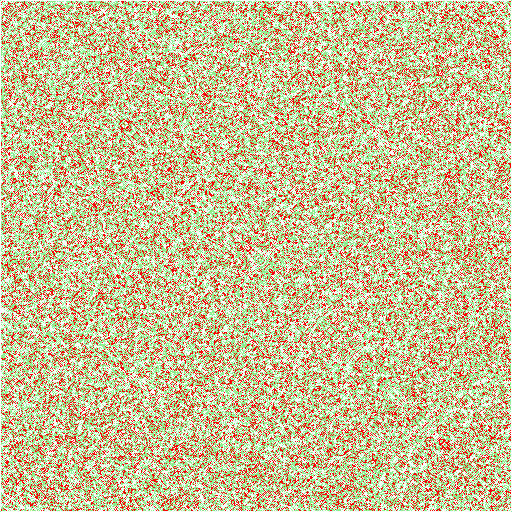

In [30]:
let
    new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
    for j ∈ 1:number_of_rows
        for k ∈ 1:number_of_columns
            new_display_frame[j,k] = myframe[j,k] |> s -> my_color_dictionary[s];
        end
    end
    display(new_display_frame)
end

### Check: Is the simulation producing the correct next states?
Fill me in

In [32]:
let
    Q = policy_model.neighborhoodstatesmap;
    R = policy_model.rule;
    N = length(train_period);
    for p ∈ 1:(N - 1)
        data = in_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        s = R[j]; # actual *next* state s
        ŝ = data[end]; # predicted *next* state ŝ
    
        # Are the actual and simulated *next* states the same?
        @assert s == ŝ
    end
end

### TODO: Explore the state dynamics of the three-color world
Fill me in

In [34]:
average_state_array = Array{Float64,2}(undef, number_of_iterations, number_of_colors)
for i ∈ 0:(number_of_iterations - 1)
    myframe = frames[i];
    for s ∈ 1:number_of_colors
        average_state_array[i+1,s] = findall(x -> x == s-1, myframe) |> length |> len -> (len/number_of_agents)
    end
end
average_state_array;

#### Visualize the evolution of the state fraction of the grid world
Fill me in

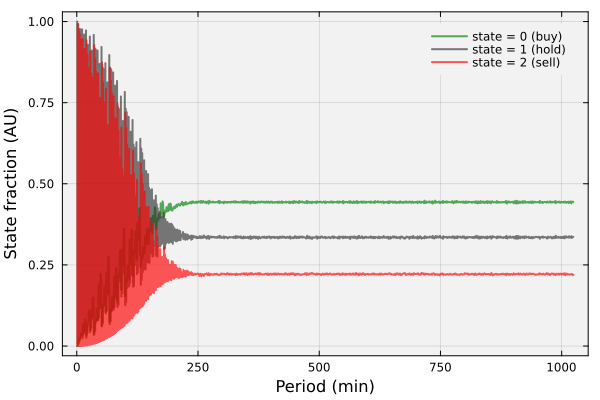

In [36]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    color_dictionary = Dict(0 =>:green,1=>:gray20,2=>:red);
    color_label_dictionary = Dict(0 => "buy", 1 => "hold", 2 => "sell");
    for s ∈ 1:number_of_colors
        plot!(q, average_state_array[:,s], label="state = $(s-1) ($(color_label_dictionary[s-1]))", 
            lw=2, c=color_dictionary[s-1], alpha=0.65)
    end
    current()
    xlabel!("Period (min)", fontsize=18)
    ylabel!("State fraction (AU)", fontsize=18)
end

#### Visualize the input and output state of a particular agent in the world
Fill me in

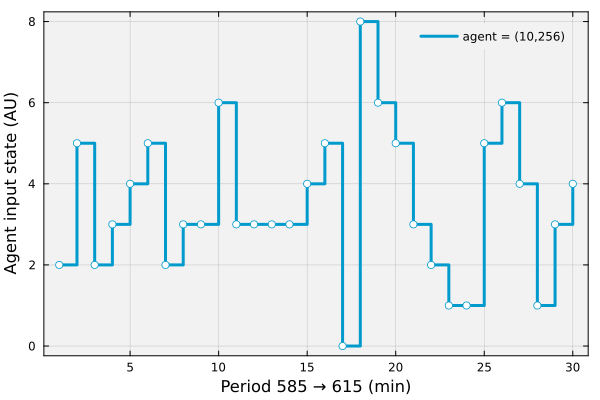

In [38]:
let
    neighborhood_state_array = Array{Int64,1}();
    Q = policy_model.neighborhoodstatesmap;
    N = length(view_period);
    for p ∈ 1:(N - 1)
        data = in_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        push!(neighborhood_state_array,j);
    end
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, neighborhood_state_array, linetype=:steppost, lw=3, c=:deepskyblue3, label="agent = ($(î),$(ĵ))")
    scatter!(neighborhood_state_array, label="", c=:white, msc=:deepskyblue3)
    xlabel!("Period $(first(view_period)) → $(last(view_period)) (min)", fontsize=18)
    ylabel!("Agent input state (AU)", fontsize=18)
end

Fill me in

In [40]:
let

    neighborhood_state_array = Array{Int64,1}();
    Q = policy_model.neighborhoodstatesmap;
    N = length(train_period);
    for p ∈ 1:(N - 1)
        data = in_sample_dataset[p];
        j = Q[round(mean(data[1:radius]), digits=2)]; # index in rule
        push!(neighborhood_state_array,j);
    end

    neighborhood_freq_dict = Dict{Int64,Float64}()
    for s ∈ 0:(number_of_states - 1)
        neighborhood_freq_dict[s] = findall(x-> x == s, neighborhood_state_array) |> length |> x-> x/(N-1)
    end

    table_df = DataFrame()
    for s ∈ 0:(number_of_states - 1)
        row_data = (
            state = s,
            frequency = neighborhood_freq_dict[s]
        );
        push!(table_df, row_data);
    end
    pretty_table(table_df)
end

┌───────┬───────────┐
│ state │ frequency │
│ Int64 │   Float64 │
├───────┼───────────┤
│     0 │      0.02 │
│     1 │      0.12 │
│     2 │      0.21 │
│     3 │      0.29 │
│     4 │      0.17 │
│     5 │      0.09 │
│     6 │      0.06 │
│     7 │      0.03 │
│     8 │      0.01 │
└───────┴───────────┘


Fill me in

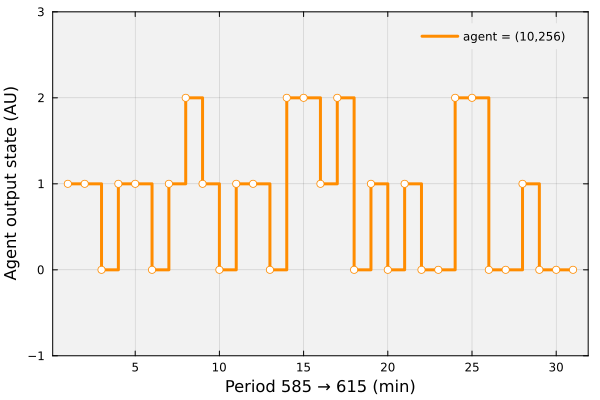

In [42]:
let
    agent_dynamics_array = Array{Int64,1}(undef, number_of_iterations)
    for k ∈ 0:(number_of_iterations - 1)
        frame = frames[k];
        agent_dynamics_array[k+1] = frame[î,ĵ];
    end
    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topright);
    plot(q, agent_dynamics_array[view_period], ylims=(-1,3), linetype=:steppost, c=:darkorange, lw=3, label="agent = ($(î),$(ĵ))")
    scatter!(agent_dynamics_array[view_period], label="", c=:white, msc=:darkorange)
    xlabel!("Period $(first(view_period)) → $(last(view_period)) (min)", fontsize=18)
    ylabel!("Agent output state (AU)", fontsize=18)
end

## Task 3: Learn the policy function by observing agent choices
Fill me in

### TODO: Formulate world and learning models
Fill me in

#### Formulate the `myworld` function

In [46]:
function myworld(model::MyWolframGridWorldModel, t::Int, s::Int, a::Int)::Tuple{Int, Float64}
    
    # initialize -
    s′ = nothing
    r = nothing
    
    # grab the parameters from the model -
    dataset = model.data;
    policymap = model.policymap;

    # what is the state, action and reward?
    data = dataset[t];
    a′ = data[end]+1; # the last element is the next state (correct for zero)
    if (a′ == a)
        r = 1.0;
    else
        r = -1.0;
    end

    # get the next state - this assumes we have full knowledge of the playback frames
    next_state_data = dataset[t+1];
    my_neighbors = next_state_data[1:end-1];
    s′ = round(mean(my_neighbors), digits=2) |> value -> policymap[value] + 1; # correct for zero

    # return -
    return (s′,r);
end;

#### Formulate the grid world model

In [48]:
worlfram_gridworld_model = build(MyWolframGridWorldModel, (
    number_of_states = length(policy_model.rule),
    data = in_sample_dataset,
    policymap = policy_model.neighborhoodstatesmap,
    world = myworld,
));

#### Formulate the Q-learning model

In [50]:
learning_model = build(MyWolframRuleQLearningAgentModel, (
    states = range(1, stop=number_of_states, step=1) |> collect,
    actions = range(1, stop=number_of_colors, step=1) |> collect,
    γ = 0.95,
    α = 0.70,
    Q = zeros(number_of_states,number_of_colors),
));

### TODO: Learn the agent policy by analyzing the in-sample frames
Fill me in

In [52]:
test = VLQuantitativeFinancePackage.sample(learning_model, worlfram_gridworld_model, 
    maxsteps = length(in_sample_dataset) - 1);

What is in Q?

In [54]:
Q̂ = test.Q

9×3 Matrix{Float64}:
  0.49       0.0       1.60004
  3.34376    5.82778   2.34461
 -0.91       6.54953   1.81805
  4.18454    3.60605   0.681253
  4.21042   -0.09485   6.70923
  5.73658    0.0       0.0
  5.63413   -0.052955  0.0
  5.65872    0.0       0.0
  0.257542   0.0       0.0

Fill me in

In [56]:
π̂ = Dict{Int64,Int64}()
for s ∈ 0:(number_of_states - 1)
    π̂[s] = argmax(Q̂[s+1,:]) - 1;
end

### Check: Is the estimated policy and the Wolfram rule the same?
Make a table

In [58]:
let
    table_df = DataFrame();
    for s ∈ 0:(number_of_states - 1)

        a = policy_model.rule[s]; # true action for state s
        â = π̂[s]; # estimated action for state s
        
        row_df = (
            s = s,
            a = a,
            â = â,
            correct = (a==â)
        );
        push!(table_df, row_df);
    end
    pretty_table(table_df)
end

┌───────┬───────┬───────┬─────────┐
│     s │     a │     â │ correct │
│ Int64 │ Int64 │ Int64 │    Bool │
├───────┼───────┼───────┼─────────┤
│     0 │     0 │     2 │   false │
│     1 │     1 │     1 │    true │
│     2 │     1 │     1 │    true │
│     3 │     0 │     0 │    true │
│     4 │     2 │     2 │    true │
│     5 │     0 │     0 │    true │
│     6 │     0 │     0 │    true │
│     7 │     0 │     0 │    true │
│     8 │     1 │     0 │   false │
└───────┴───────┴───────┴─────────┘


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

In [60]:
# for i ∈ 0:(number_of_iterations - 1)
#     myframe = frames[i];
#     new_display_frame = Array{RGB,2}(undef, number_of_rows, number_of_columns);
#     for j ∈ 1:number_of_rows
#         for k ∈ 1:number_of_columns
#             new_display_frame[j,k] = myframe[j,k] |> s -> my_color_dictionary[s];
#         end
#     end
#     display(new_display_frame)
#     IJulia.clear_output(true)
# end